# Webscraping: Date extraction

Make a graph of the amount of articles there were on a day on a given topic. Use marketwatch.com, but now also loop trough different result pages instead of just one.

**note**: This notebook contains date-dependent results. If you run this notebook yourself, you will almost certainly get different results than the ones described here

### 1. Importing the necessary packages

In [1]:
import requests
from bs4 import BeautifulSoup
from newspaper import Article

from datetime import datetime
from collections import Counter
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 2. Defining the search term and the search url

In [2]:
SEARCH_TERM = "Cisco"
search_url = lambda article: f"https://www.marketwatch.com/search?q={SEARCH_TERM}&Link=MW_SearchAC&mp=806&o={article}"
ARTICLES_PER_PAGE = 15

### 3. Extracting the links

In [3]:
headers = {"user-agent": "Chrome/84.0.4147"}
articles_urls = []
start_time = time.time()
for page in range(0, 7):
    print(f"Starting on page {page + 1}. Current time: {round(time.time() - start_time, 1)}", end="\r")
    url = search_url(1 + page * ARTICLES_PER_PAGE)
    
    # timeout: avoid to hang indefinitely by telling Requests to only wait for maximum 10 seconds on a response
    try:
        result = requests.get(url, headers=headers, timeout=10)
    except requests.exceptions.Timeout:
        print("\n Unable to load page")
        time.sleep(3)
        
    html_soup = BeautifulSoup(result.text)
    elements = html_soup.find_all(attrs={"class": "searchresult"})
    for element in elements:
        articles_urls.append(element.find("a").get("href"))
    # why do this? To avoid going too fast, Marketwatch doesn't like that.
    time.sleep(0.5)

### 4. Use newspaper to extract the keywords

In [4]:
dates = []
articles = []

start_time = time.time()

for i, article_url in enumerate(articles_urls):
    print(f"Starting on article {i + 1}. Current time: {round(time.time() - start_time, 1)}", end="\r")
    # Note: marketwatch sometimes doesnt provide the beginning of the link!
    if article_url.startswith("http://www.marketwatch.com"):
        article = Article(article_url)
    else:
        article = Article("http://www.marketwatch.com" + article_url)
        
    article.download()
    # why do this? To avoid going too fast, Marketwatch doesn't like that.
    while article.download_state != 2: # 2 is SUCCESS state
        time.sleep(2)
        print("\n Article download failed")
        article.download()

    article.parse()
    
    if article.publish_date is not None:
        # calling it directly like this allows us to get the scores of the keywords too
        dates.append(article.publish_date)
        
    # always keep the article in case you need it afterwards -> this way you don't need to download it again
    articles.append(article)

Starting on article 5. Current time: 4.5
 Article download failed


In [5]:
len(dates)

72

Unfortunately from the 105 articles newspaper was only able to extract 72 dates! Dates is by far the most difficult field for Newspaper. We will fix this using Beautiful Soup to manually extract the dates

In [6]:
dates = []
for article in articles:
    html_soup = BeautifulSoup(article.html)
    date = html_soup.find(attrs={"class": "timestamp"}).text
    if date is not None:
        date = date[date.find(":") + 2:]
        date_stripped = " ".join(date.split(" ")[0:3])
        try:
            date_object = datetime.strptime(date_stripped, "%b. %d, %Y")
        except ValueError:
            date_object = datetime.strptime(date_stripped, "%B %d, %Y")
        dates.append(date_object)

In [7]:
len(dates)

105

In [8]:
count_dates = Counter(dates)

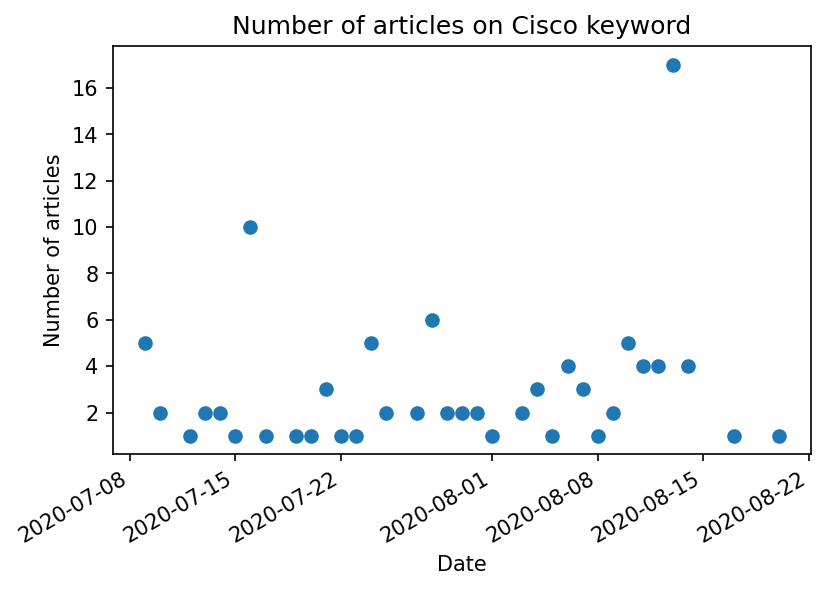

In [9]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(list(count_dates.keys()), list(count_dates.values()))
# beautify the x-labels
plt.gcf().autofmt_xdate()
ax.set_title(f"Number of articles on {SEARCH_TERM} keyword")
ax.set_xlabel("Date")
ax.set_ylabel("Number of articles")
plt.show()

What happened on August 13? Let's take a look!

In [10]:
for i, date in enumerate(dates):
    if str(date).startswith("2020-08-13"):
        print(articles[i].title)

S&P 500 ends lower in struggle to set record high as investors turn to tech stocks and stimulus talks flounder
Cisco stock logs worst day in nearly a decade as cost cuts create more coronavirus concerns
Stocks Close Nearly Flat After Jobless Claims Data
Cisco, Exxon Mobil share losses lead Dow's nearly 75-point drop
Cisco, Exxon Mobil share losses contribute to Dow's 150-point drop
Cisco Slides on Weak Outlook, Dragging Down Other Enterprise IT Stocks
Cisco Beat Earnings Expectations. Why Its Stock Is Dropping.
Charting a tandem breakout attempt: S&P 500, Nasdaq press record territory
ETFs with big Cisco stakes fall as network-equipment giant's stock set for worst day in 9 years
Cisco stock slides toward worst day since 2011 after earnings
Dow's 70-point drop led by losses in Cisco, Walgreens Boots stocks
Stock-index futures pare losses as jobless claims fall below 1 million
Cisco Systems stock price target cut to $46 from $50 at J.P. Morgan
Thursday Premarket Stock Movers: Cisco, Micr

We found out when Cisco lost a lot of its stock price just based an news article coverage!